In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [90]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56438 sha256=3a532894559afc3844b35577661f46642839e2fd557bd463c8773328c5fce4ae
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [61]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms

In [62]:
skin_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [63]:
for i in skin_data.columns:
    dt = {f"Unique values in {i}:  {skin_data[i].unique()}"}
    print(dt)

{"Unique values in lesion_id:  ['HAM_0000118' 'HAM_0002730' 'HAM_0001466' ... 'HAM_0005579' 'HAM_0001576'\n 'HAM_0002867']"}
{"Unique values in image_id:  ['ISIC_0027419' 'ISIC_0025030' 'ISIC_0026769' ... 'ISIC_0033536'\n 'ISIC_0032854' 'ISIC_0032258']"}
{"Unique values in dx:  ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']"}
{"Unique values in dx_type:  ['histo' 'consensus' 'confocal' 'follow_up']"}
{'Unique values in age:  [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.\n 15.]'}
{"Unique values in sex:  ['male' 'female' 'unknown']"}
{"Unique values in localization:  ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'\n 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']"}


bkl: Benign keratosis-like lesions

nv: Melanocytic nevi (moles)

df: Dermatofibroma

mel: Melanoma (a type of skin cancer)

vasc: Vascular lesions

bcc: Basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma

In [64]:
le = LabelEncoder()
skin_data["label"] = le.fit_transform(skin_data['dx'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


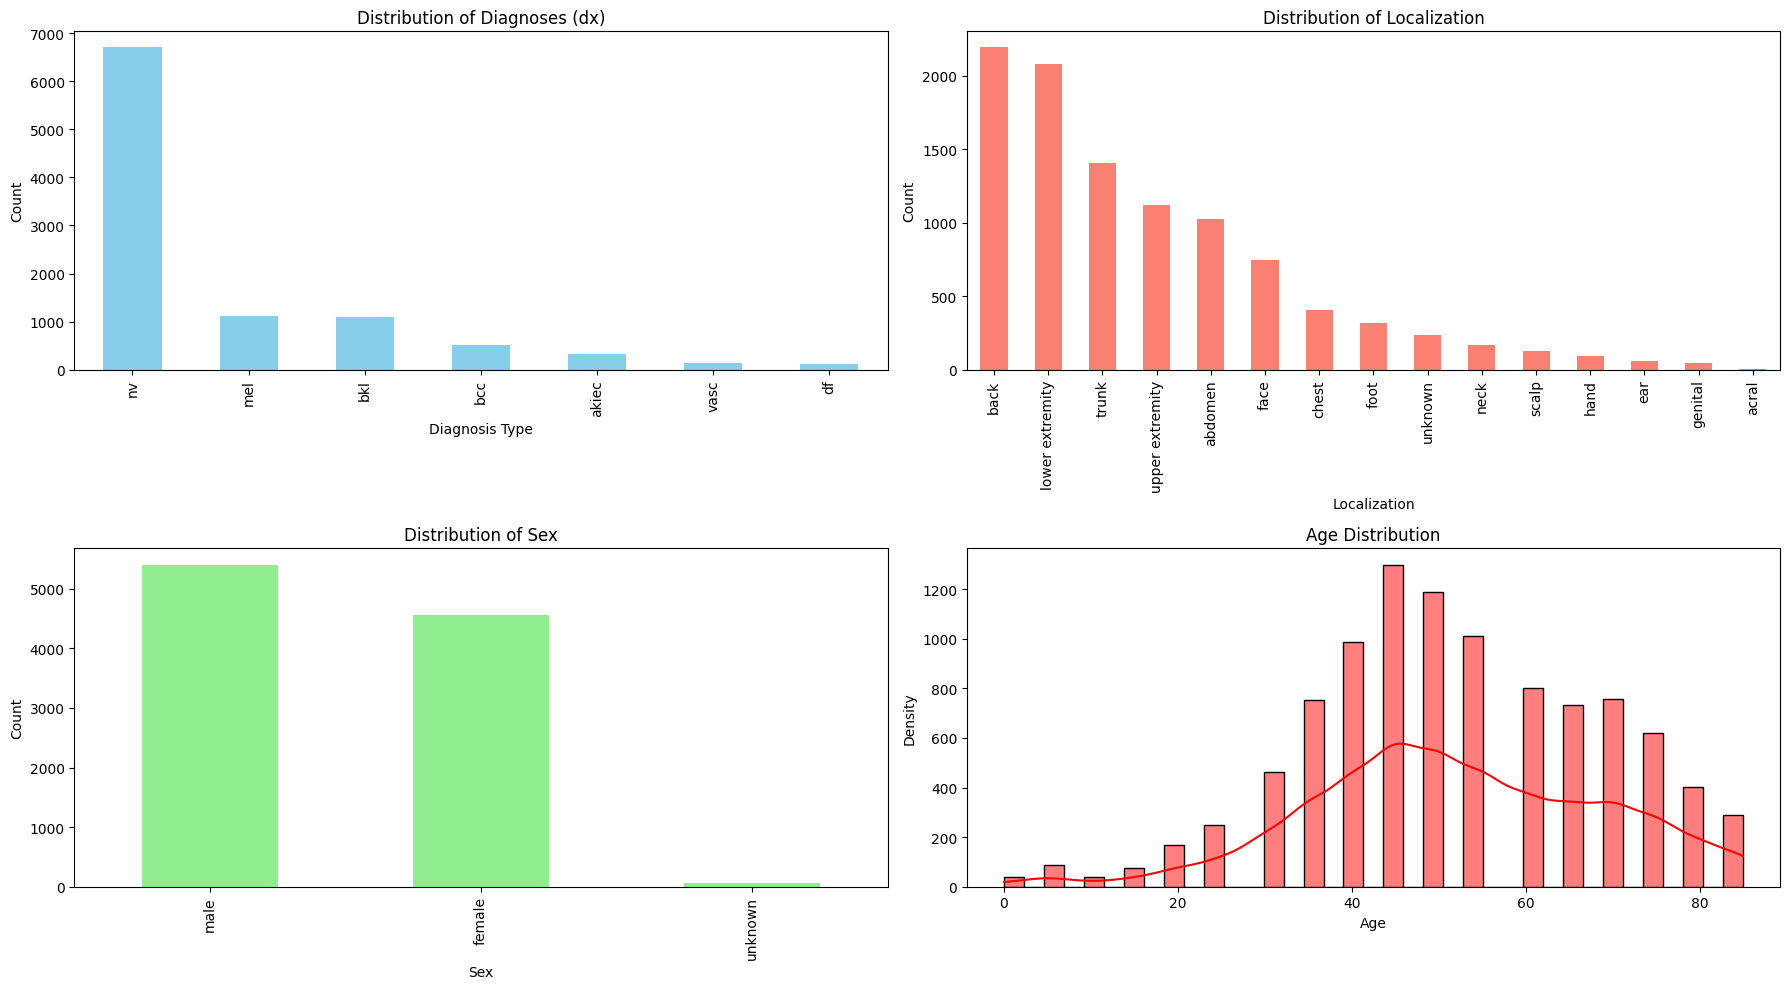

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot the 'dx' column
skin_data['dx'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Diagnoses (dx)')
axes[0, 0].set_xlabel('Diagnosis Type')
axes[0, 0].set_ylabel('Count')

# Plot the 'localization' column
skin_data['localization'].value_counts().plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution of Localization')
axes[0, 1].set_xlabel('Localization')
axes[0, 1].set_ylabel('Count')

# Plot the 'sex' column
skin_data['sex'].value_counts().plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution of Sex')
axes[1, 0].set_xlabel('Sex')
axes[1, 0].set_ylabel('Count')

# Plot the 'age' distribution
sns.histplot(skin_data['age'].dropna(), kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_title('Age Distribution')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [66]:
skin_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0


In [67]:
n_samples= 500 

dfs = [skin_data[skin_data['label'] == i] for i in range(7)]
dfs_balanced = [resample(df, replace=True, n_samples=n_samples, random_state=42) for df in dfs]
skin_df_balanced = pd.concat(dfs_balanced)


In [68]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6


In [89]:
# Create an empty dictionary to store image paths
image_path = {}

# Loop through all image files in the HAM10000 directory
for img in glob('/kaggle/input/skin-cancer-mnist-ham10000/**/*.jpg'):
    # Get the image ID (file name without the .jpg extension)
    image_id = os.path.splitext(os.path.basename(img))[0]
    # Add the image ID and its full path to the dictionary
    image_path[image_id] = img


In [90]:
skin_df_balanced['path'] = skin_data['image_id'].map(image_path.get)
skin_df_balanced.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...


In [72]:
# Define a custom dataset class for PyTorch
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).resize((SIZE, SIZE))
        if self.transform:
            image = self.transform(image)
        return image, label

In [73]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Split dataset
train_df, test_df = train_test_split(skin_df_balanced, test_size=0.25, random_state=42)
train_dataset = SkinCancerDataset(train_df, transform=transform)
test_dataset = SkinCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [74]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Set the number of images per diagnosis to display
# images_per_diagnosis = 4

# # Get the unique diagnosis types
# diagnosis_types = skin_df_balanced['dx'].unique()

# # Set up the figure and axes for the grid
# fig, axes = plt.subplots(len(diagnosis_types), images_per_diagnosis, figsize=(20, len(diagnosis_types) * 4))

# # Loop through each diagnosis type
# for i, diagnosis in enumerate(diagnosis_types):
#     # Filter images for the current diagnosis
#     images = skin_df_balanced[skin_df_balanced['dx'] == diagnosis]['image'].sample(n=images_per_diagnosis, random_state=42)

#     # Loop through the number of images to display for this diagnosis
#     for j in range(images_per_diagnosis):
#         if j < len(images):  # Ensure we don't go out of bounds
#             axes[i, j].imshow(images.iloc[j])  # Show the image
#             axes[i, j].set_title(diagnosis)  # Set title for the image
#         axes[i, j].axis('off')  # Turn off axes

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()



In [75]:
# X = np.asarray(skin_df_balanced['image'].tolist())
# X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.

# Y=skin_df_balanced['target'] #Assign label values to Y
# Y_cat = to_categorical(Y, num_classes=7)

In [76]:
SIZE = 128

class SkinCancerClassifier(nn.Module):
    def __init__(self):
        super(SkinCancerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * (SIZE//8) * (SIZE//8), 32)
        self.fc2 = nn.Linear(32, 7)  # 7 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 256*16*16
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x))) # 128*8*8
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x))) # 64*4*4
        x = self.dropout(x)
        x = x.view(-1, 64 * (SIZE//8) * (SIZE//8)) 
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SkinCancerClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [79]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
        total_predictions += labels.size(0)  # Count total predictions

    # Calculate and print accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/15], Loss: 0.8602, Accuracy: 67.85%
Epoch [2/15], Loss: 0.6835, Accuracy: 75.28%
Epoch [3/15], Loss: 0.5350, Accuracy: 80.88%
Epoch [4/15], Loss: 0.4583, Accuracy: 83.58%
Epoch [5/15], Loss: 0.3726, Accuracy: 86.51%
Epoch [6/15], Loss: 0.3094, Accuracy: 88.95%
Epoch [7/15], Loss: 0.2712, Accuracy: 90.36%
Epoch [8/15], Loss: 0.2092, Accuracy: 92.61%
Epoch [9/15], Loss: 0.2619, Accuracy: 91.28%
Epoch [10/15], Loss: 0.1932, Accuracy: 92.99%
Epoch [11/15], Loss: 0.1681, Accuracy: 94.25%
Epoch [12/15], Loss: 0.1440, Accuracy: 94.90%
Epoch [13/15], Loss: 0.1454, Accuracy: 94.59%
Epoch [14/15], Loss: 0.1504, Accuracy: 94.82%
Epoch [15/15], Loss: 0.1121, Accuracy: 96.11%


Test Accuracy: 75.09%


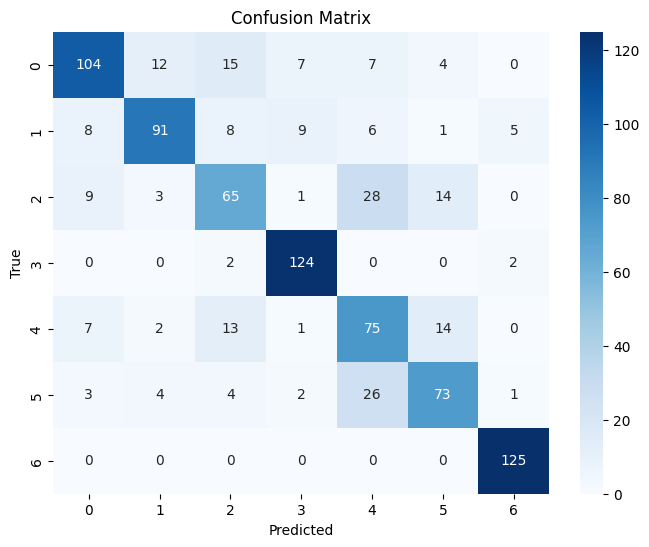

In [81]:
from sklearn.metrics import confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Calculate confusion matrix and accuracy
cm = confusion_matrix(y_true, y_pred)
acc = (np.trace(cm) / np.sum(cm)) * 100
print(f"Test Accuracy: {acc:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [84]:
# Save the trained model
torch.save(model.state_dict(), 'skin_disease_classifier.pth')

In [85]:
model.load_state_dict(torch.load('skin_disease_classifier.pth'))

/tmp/ipykernel_30/2266559380.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('skin_disease_classifier.pth'))


<All keys matched successfully>

In [111]:
sample_data = skin_df_balanced.sample(4)[['dx', 'path', 'label']]

# Convert the sampled DataFrame to a list of lists
sample_list = sample_data.values.tolist()

# Print the result
print(sample_list)

[['mel', '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033905.jpg', 4], ['df', '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0024330.jpg', 3], ['akiec', '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028872.jpg', 0], ['vasc', '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027672.jpg', 6]]


In [125]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB images
])

class_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

# Load the image
image = Image.open('/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027672.jpg')

# Preprocess the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    class_idx = predicted.item()

    # Use the mapping to get the class name
    class_name = class_mapping.get(class_idx, "Unknown Class")
    
    print(f'Predicted Class Index: {class_idx}')
    print(f'Predicted Class Name: {class_name}')


Predicted Class Index: 6
Predicted Class Name: vasc


In [ ]:
0:akiec, 1:bcc, 2: bkl, 3:df , 4:mel, 5:nv , 6:vasc